In [1]:
import numpy as np
import pandas as pd
import re
import nltk   
import random
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# Verilere Genel Bir Bakış

In [2]:
df=pd.read_excel("C:\\Users\\Dell\\Desktop\\NLP\\Case Study 1\\amazon.xlsx")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [3]:
df.tail()

,Star,HelpFul,Title,Review
5606,4,0,Recommend,Great product for reasonable money. Delivered...
5607,5,0,"Terrible , different colors. I returned",Color is way off and panels do not match
5608,5,0,Extremely pleasing,These are great for my studio as they compleme...
5609,5,0,Perfect,Brought out the beauty in kids room. They love...
5610,4,0,Quality Curtains for the price,Very cute curtains in my sons room! Thick enou...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


In [5]:
df.isnull().sum()

Star        0
HelpFul     0
Title      52
Review     18
dtype: int64

In [6]:
df["Star"].value_counts()

Star
5    4126
4     588
1     368
3     315
2     214
Name: count, dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Star,5611.0,4.406166,1.170291,1.0,4.0,5.0,5.0,5.0
HelpFul,5611.0,0.984495,4.109631,0.0,0.0,0.0,1.0,124.0


# Metin Ön İşleme

In [8]:
df["Review"]=df["Review"].str.lower() # küçük harfe çevirme
df["Review"]

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windows.<br />imag...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i can't believe the qu...
                              ...                        
5606    great product for reasonable money.  delivered...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609    brought out the beauty in kids room. they love...
5610    very cute curtains in my sons room! thick enou...
Name: Review, Length: 5611, dtype: object

In [9]:
# noktalama işaretlerini kaldırma
df["Review"]=df['Review'].apply(lambda x: re.sub("[^\w\s]","", str(x)))
df["Review"]

0                                           happy with it
1       good quality material however the panels are m...
2       product was fun for bedroom windowsbr imagery ...
3        lo unico que me gustaria es que sean un poco ...
4       great bang for the buck i cant believe the qua...
                              ...                        
5606    great product for reasonable money  delivered ...
5607             color is way off and panels do not match
5608    these are great for my studio as they compleme...
5609     brought out the beauty in kids room they love it
5610    very cute curtains in my sons room thick enoug...
Name: Review, Length: 5611, dtype: object

In [10]:
df["Review"][125:130] 

125    great i feel like ive gone to tahiti i placed ...
126    i purchased the 4 seasons print and couldnt be...
127    it does not look as vibrant and dramatic as th...
128    i wish they had wider ones but the 108 inches ...
129    really pretty design looks just like the pictu...
Name: Review, dtype: object

In [11]:
df["Review"]=df['Review'].fillna('').apply(lambda x: ''.join([i for i in x if not i.isdigit()])) # sayısal ifadeleri kaldırma
df["Review"][125:130]

125    great i feel like ive gone to tahiti i placed ...
126    i purchased the  seasons print and couldnt be ...
127    it does not look as vibrant and dramatic as th...
128    i wish they had wider ones but the  inches fit...
129    really pretty design looks just like the pictu...
Name: Review, dtype: object

In [12]:
# stopwords kelimelerini kaldırma
nltk.download("stopwords")
sw=stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df["Review"]=df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df["Review"]

0                                                   happy
1         good quality material however panels mismatched
2       product fun bedroom windowsbr imagery bit stre...
3       lo unico que gustaria es que sean un poco mas ...
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                               color way panels match
5608    great studio complement entire theme studioliv...
5609                        brought beauty kids room love
5610      cute curtains sons room thick enough keep light
Name: Review, Length: 5611, dtype: object

In [14]:
temp_df=pd.Series(" ".join(df["Review"]).split()).value_counts() #1000 den az olan kelimeleri df den çıkartıyoruz.
temp_df

curtains        1891
love            1312
room            1116
like            1037
beautiful        943
                ... 
encantarón         1
neato              1
decormatches       1
thx                1
studioliving       1
Name: count, Length: 6698, dtype: int64

In [15]:
drops=temp_df[temp_df<2]
drops

vaulted         1
umph            1
reevaluated     1
grass           1
remodeling      1
               ..
encantarón      1
neato           1
decormatches    1
thx             1
studioliving    1
Name: count, Length: 3694, dtype: int64

In [16]:
df["Review"]=df["Review"].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))
df["Review"]

0                                                   happy
1                    good quality material however panels
2       product fun bedroom windowsbr imagery bit stre...
3                               lo que es que un poco mas
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                               color way panels match
5608    great studio complement entire theme area phot...
5609                        brought beauty kids room love
5610      cute curtains sons room thick enough keep light
Name: Review, Length: 5611, dtype: object

In [17]:
# lemmatization
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['Review']

0                                                   happy
1                     good quality material however panel
2       product fun bedroom windowsbr imagery bit stre...
3                                 lo que e que un poco ma
4       great bang buck cant believe quality material ...
                              ...                        
5606    great product reasonable money delivered quick...
5607                                color way panel match
5608    great studio complement entire theme area phot...
5609                         brought beauty kid room love
5610        cute curtain son room thick enough keep light
Name: Review, Length: 5611, dtype: object

# Metin Görselleştirme

In [18]:
tf=pd.DataFrame(temp_df)
tf.reset_index(inplace=True)
tf.columns=["words","tf"]
tf.head()

,words,tf
0,curtains,1891
1,love,1312
2,room,1116
3,like,1037
4,beautiful,943


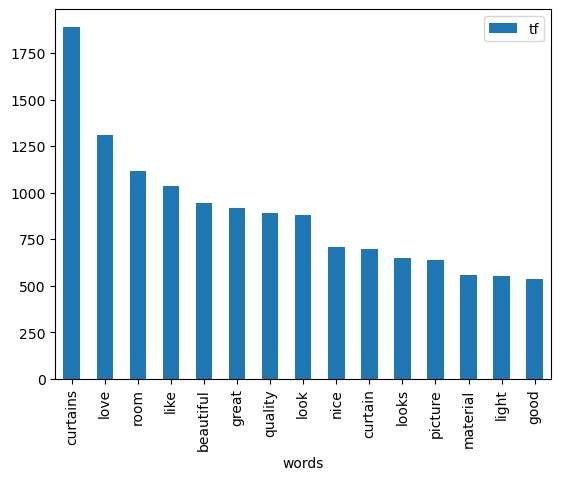

In [19]:
tf[tf["tf"]>500].plot.bar(x="words",y="tf");

In [20]:
text=" ".join(i for i in df.Review)

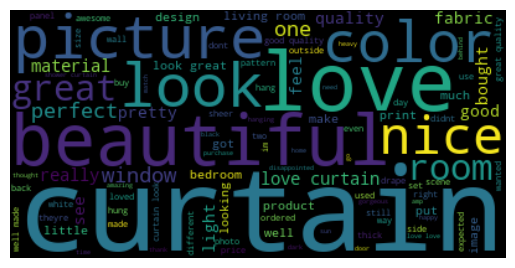

In [21]:
wordcloud=WordCloud(max_font_size=1000, max_words=100, background_color="black").generate(text)
plt.figure()
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

# SentimentIntensityAnalyzer

In [22]:
sia=SentimentIntensityAnalyzer()

In [23]:
df["sentiment_label"]=df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"]>0 else "nef")
df.head(10)

,Star,HelpFul,Title,Review,sentiment_label
0,5,0,looks great,happy,pos
1,5,0,Pattern did not align between the two panels.,good quality material however panel,pos
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...,pos
3,5,0,Que se ven elegantes muy finas,lo que e que un poco ma,nef
4,5,0,Wow great purchase,great bang buck cant believe quality material ...,pos
5,5,0,Not for us,look different photo,nef
6,5,0,Perfect for spa room,exactly looking heavy material great price fast,pos
7,5,0,Actually better than expected,looking picture thought curtain would thinner ...,pos
8,4,0,Not what expected,much thought would wasnt really expecting want...,nef
9,5,0,Pretty as a Picture,curtain picture show rd set ambesonne curtain ...,pos


In [24]:
df.tail(10)

,Star,HelpFul,Title,Review,sentiment_label
5601,5,0,Festive Addition,heavy good quality curtain image bright good f...,pos
5602,5,0,Tree life curtain,hung seam bottom even part longer others still...,pos
5603,5,0,Very pretty,using room divider privacy office much prettie...,pos
5604,5,0,Got my more than moneys worth,material way better photo provided happy purch...,pos
5605,5,0,My daughter loves these,long floor curtain rod cover short window well...,pos
5606,4,0,Recommend,great product reasonable money delivered quick...,pos
5607,5,0,"Terrible , different colors. I returned",color way panel match,nef
5608,5,0,Extremely pleasing,great studio complement entire theme area phot...,pos
5609,5,0,Perfect,brought beauty kid room love,pos
5610,4,0,Quality Curtains for the price,cute curtain son room thick enough keep light,pos


In [25]:
df["sentiment_label"].value_counts()

sentiment_label
pos    4764
nef     847
Name: count, dtype: int64

In [26]:
df.groupby("sentiment_label")["Star"].mean()

sentiment_label
nef    3.409681
pos    4.583333
Name: Star, dtype: float64

# Modeli oluşturma

In [27]:
df["sentiment_label"]=LabelEncoder().fit_transform(df["sentiment_label"])
y=df["sentiment_label"]
X=df["Review"]

In [28]:
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=14)

In [29]:
tf_idf=TfidfVectorizer().fit(x_train)
x_train_tf_idf=tf_idf.transform(x_train)
x_test_tf_idf=tf_idf.transform(x_test)

# Makine Öğrenmesi

In [30]:
# Logistic Regression
log_model=LogisticRegression().fit(x_train_tf_idf,y_train)
cross_val_score(log_model,
                x_train_tf_idf,
                y_train,
                scoring="accuracy",
                cv=5).mean()

0.8873550037987805

In [31]:
y_pred=log_model.predict(x_test_tf_idf)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.28      0.94      0.43        65
           1       1.00      0.88      0.94      1338

    accuracy                           0.89      1403
   macro avg       0.64      0.91      0.68      1403
weighted avg       0.96      0.89      0.91      1403



In [53]:
number=random.randint(0,996)
data=pd.DataFrame(X[number:number+10],columns=["Review"])
data["real"]=y[number:number+10]
data["predict"]=log_model.predict(tf_idf.fit(x_train).transform(data["Review"].values))
data

,Review,real,predict
589,cool,1,1
590,quality curtain beautiful picture,1,1
591,great quality,1,1
592,nicely made,1,1
593,really cool son red white blue bedroom love cu...,1,1
594,dont hang rod well,0,1
595,material beautiful design love,1,1
596,nice love,1,1
597,everyone love friend family,1,1
598,absolutely perfect probably order another,1,1


In [33]:
# Random Forest Classifier
rf_model=RandomForestClassifier().fit(x_train_tf_idf,y_train)
cross_val_score(rf_model,
                x_train_tf_idf,
                y_train,
                scoring="accuracy",
                cv=5,
                n_jobs=-1).mean()

0.9089800910012682

In [34]:
y_pred=rf_model.predict(x_test_tf_idf)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.64      0.84      0.73       167
           1       0.98      0.94      0.96      1236

    accuracy                           0.93      1403
   macro avg       0.81      0.89      0.84      1403
weighted avg       0.94      0.93      0.93      1403



In [41]:
number=random.randint(0,996)
data=pd.DataFrame(X[number:number+10],columns=["Review"])
data["real"]=y[number:number+10]
data["predict"]=rf_model.predict(tf_idf.fit(x_train).transform(data["Review"].values))
data

,Review,real,predict
450,curtain better expected walk room look like oc...,1,1
451,ordered teen daughter room different term woul...,1,1
452,pretty even light behind,1,1
453,nice curtain received allot compliment,1,1
454,hang closet bedroom love,1,1
455,good,1,1
456,washed looking big hope going work disappointed,0,0
457,look fantastic especially placed true picture,1,1
458,disappointment purchase photo amazon website g...,1,1
459,,0,0
